<img src=https://machinelearningsol.com/wp-content/uploads/2019/09/1.png width="400">

<h1 style="text-align:center;font-size:30px;" > Tweet Sentiment Analysis Project </h1>

<h1> 1. Business Problem </h1>

Classify the tweets by implementing any NLP approach for Sentiment analysis on the provided dataset. The objective is to recognize whether the given tweet is oriented as negative (-1), neutral (0), or positive (1) tone. Focus majorly on unique preprocessing techniques.

## Importing Necessary Libraries

In [2]:
import nltk
import re
import pickle
from emot.emo_unicode import UNICODE_EMOJI
import os
import csv
from nltk.stem.snowball import SnowballStemmer
from nltk import sent_tokenize, word_tokenize
import random
from nltk.classify import SklearnClassifier
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import pandas as pd
import string

from wordcloud import WordCloud
import matplotlib.pyplot as plt
st_wrds = stopwords.words('english')
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [3]:
## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

## Loading Dataset

In [4]:
df = pd.read_csv(r"archive/Twitter_Data.csv")

In [4]:
#Getting the overview of data
df.sample(7)

,clean_text,category
149702,modi’ mantra everyone fool rule,0.0
73394,ager yahi mission failed hota sab called liber...,-1.0
93771,addresses public meeting jammu\n,0.0
43863,narendra modi says india shoots down low orbit...,1.0
31962,wait milan supporting ubi next time you say mo...,1.0
49534,while making the announcement about mission sh...,1.0
141589,bjp has not won even single seat from kerala t...,1.0


In [5]:
#Renaming clean_text column to tweet
df.rename(columns={'clean_text':'tweet'}, inplace=True)
df.columns

Index(['tweet', 'category'], dtype='object')

In [6]:
#checking the number of rows and columns on our dataset i.e. dimensions
print("Our Dataset has {} rows and {} columns".format(df.shape[0],df.shape[1]))

Our Dataset has 162980 rows and 2 columns


In [7]:
#checking the datatype of each columns
df.dtypes

tweet        object
category    float64
dtype: object

In [8]:
#Getting more detail about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   tweet     162976 non-null  object 
 1   category  162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [9]:
#Checking for missing values in each columns
df.isnull().sum()

tweet       4
category    7
dtype: int64

**Insight:** clean_text columns and category has 4 and 7 missing values respectively

- Since the number of missing values are very low we will drop these rows

In [10]:
df.dropna(inplace = True)

In [11]:
#checking for missing values again
df.isnull().sum()

tweet       0
category    0
dtype: int64

- No missing data in our Dataset

In [12]:
#checking the dimension of the dataset after dropping the rows with missing values
print("Dataset has {} rows and {} columns after dropping missing values.".format(df.shape[0],df.shape[1]))

Dataset has 162969 rows and 2 columns after dropping missing values.


-  Initially Our Dataset has __162980 rows__ and __2 columns__. Hence __11 rows__ were dropped.

__After analysisng the given data initially, we will preprocess our text data and then after preprocessng the text we will perform some exploratory data analysis on the cleaned text__

# Pre-Processing the text

__Basic Feature of a tweet__
- A tweet may contain the mentions starting with @username i.e. twitter handle of users.
- A tweet may contain hashtags i.e. #
- A tweet may contain links starting with http:// or https://
- A tweet may contain emojis.
- Text in language other than English<br> </br>
- Tweet may contain __emoji__ and __emoticon__ 🤣😊😉

NOTE: We will try to remove each of them one by one because they will be of no use for us while analysing and training the models.This will also help us to decrease the dimnesionality of the text data.

### Function for converting emojis into word

* Both emoji and emoticon convey emotional expression in a text message for text analysis we might need to handle it carefully.
* Removing the emojis/emoticons from the text for text analysis might not be a good decision. Sometimes, they can give strong information about a text such as feeling expression, especially in Sentiment Analysis and removing them might not be the right solution.<br></br>

__For example__-In reviews sentiment analysis for any product, we try to identify each review text whether it is positive or negative. In this case, removing the emojis/emoticons is not the right decision because we can lose valuable information. A better approach is to convert emoji to word format so that it preserves the emoji information.<br></br>
Jhon: "I absolutely ❤️ this Laptop. Thankyou 🙂" <br></br>
In the above review, we can replace ‘❤️’ with ‘Love or like and 🙂 with ‘smiling face’.

In [13]:
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(": ","").split()))
    return text

In [14]:
text1 = "Hilarious 😂. The feeling of making a sale 😎, The feeling of actually fulfilling orders 😒 goat✌"

convert_emojis(text1)

'Hilarious :face_with_tears_of_joy:. The feeling of making a sale :smiling_face_with_sunglasses:, The feeling of actually fulfilling orders :unamused_face: goat:victory_hand:'

### Create a function to clean the tweets

In [15]:
#create a function to clean the tweets
def clean_text(text):
    text = convert_emojis(text) #calling the convert_emojis function to convert all the emojis to text at first place.
    text = str(text)
    text = text.lower() #converting every words to lowercase
    text = re.sub(r'@[A-Za-z0-9_-]+', '', text) #substituing the @user_handle with empty string
    text = re.sub(r'#', '', text) #Remove the '#' symbol
    text = re.sub(r'RT[\s]+', '', text) #Removing retweets RT
    text = re.sub(r'https?:\/\/\S+', '', text) #removing the hyperlink
    text = re.sub(r'[0-9]+', '', text) #Removing numbers from the text
    
    words = word_tokenize(text) #Splitting each words in a sentence
    
    #use regular expressions to select for the punctuation characters and use the sub() function to replace them with nothing.
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    text = [re_punc.sub('', w) for w in words]
    
    #removing stop words
    text = [word for word in text if not word in st_wrds]
    
    #removing text with length 1
    text = [word for word in text if len(word) > 1 ]
      
    text = ' '.join([elem for elem in text]) #Converting the whole text into a string
    text = re.sub(' +', ' ', text) #Removing extra spaces from the text
    
    return text

In [16]:
#Testing the function
lin = 'this is a very good 100news @indian_u@ser :-) $ & * - -_ #yea24rs 33.65 😘 @sEcons24s_user. a 😎session a look https://rogercake.github.io #GoodMovement'
clean_text(lin)
len(lin.split())

23

### Creating new cleaned text column

In [17]:
# df['clean_tweet'] = df['tweet'].apply(clean_text)
'''I ran this code in google collab because it was time consuming and saved a copy of cleaned text as "clean_file.csv"
    '''

'I ran this code in google collab because it was time consuming and saved a copy of cleaned text as "clean_file.csv"\n    '

## Loading Cleaned data after preprocessing text and saving in new column clean_tweet

In [18]:
new_df = pd.read_csv('clean_file.csv', sep='|')

### Analysing Cleaned Text Data

In [19]:
print(new_df.isna().sum())
print('*'*20)
new_df.shape

tweet           0
category        0
clean_tweet    72
dtype: int64
********************


(162969, 3)

In [20]:
new_df['category'][new_df['clean_tweet'].isna()].value_counts()

0.0    67
1.0     5
Name: category, dtype: int64

- After text preprocessing there were 72 rows which doesnot have any meaningful word left and hence they are empty.
- We will remove those empty rows from our dataset

In [21]:
new_df.dropna(inplace=True)

In [22]:
print(new_df.isna().sum())
print('*'*20)
new_df.shape

tweet          0
category       0
clean_tweet    0
dtype: int64
********************


(162897, 3)

In [23]:
def remove_non_alpha_char(text):
    sent = []
    for word in text.split():
        if word.isalpha() == True:
            sent.append(word)
        
    text = ' '.join([elem for elem in sent]) #Converting the whole text into a string
    text = re.sub(' +', ' ', text) 
    return text

In [24]:
new_df['new_clean_tweet'] = new_df['clean_tweet'].apply(remove_non_alpha_char)

In [25]:
new_df.sample(5)

,tweet,category,clean_tweet,new_clean_tweet
87324,their hatred for modi politicians lobbyists li...,1.0,hatred modi politicians lobbyists liberals med...,hatred modi politicians lobbyists liberals med...
49854,india news nirav modi extradition cbied team l...,0.0,india news nirav modi extradition cbied team l...,india news nirav modi extradition cbied team l...
79880,modis real surgical strike out open warns cent...,1.0,modis real surgical strike open warns centre m...,modis real surgical strike open warns centre m...
135860,why every modi supporters lie the nation,0.0,every modi supporters lie nation,every modi supporters lie nation
91023,win win priyanka will restrict modi into campa...,1.0,win win priyanka restrict modi campaigning var...,win win priyanka restrict modi campaigning var...


### Function to create WordCloud

In [26]:
def plot_word_cloud(dt, text_col, category_col, label, max_words = 100):
    '''
    Here, dt = Datframe
          text_col = pass column name containing text as string 
          category_col = pass the name of the lable or target column as string
          label = pass the label
    '''
    corpus = dt[text_col][dt[category_col] == label].to_list()
    text = ' '.join(corpus)

    wordcloud = WordCloud(max_font_size=200,
                          max_words= max_words,
                          background_color='black',
                          scale=10,
                          width=800,
                          height=400).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud,
               interpolation='bilinear') #to make the displayed image appear more smoothly
    plt.axis('off')
    plt.show()

### WordCloud for Positive Reviews

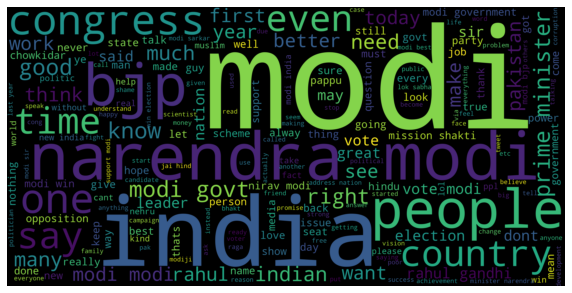

In [27]:
plot_word_cloud(new_df, 'new_clean_tweet', 'category', 1, max_words = 200)

### WordCloud for Negative Reviews

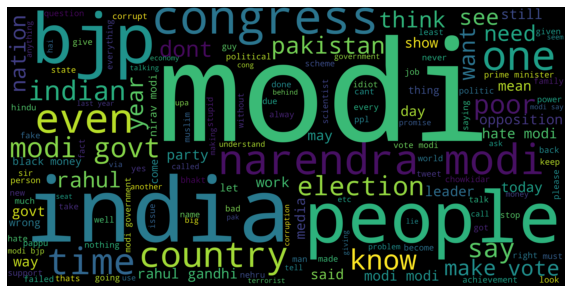

In [28]:
plot_word_cloud(new_df, 'new_clean_tweet', 'category', -1, max_words=150)

### WordCloud for Neutral Reviews

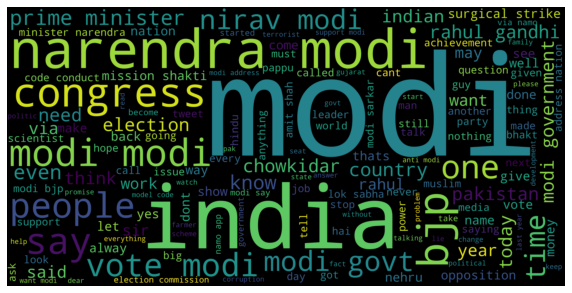

In [29]:
plot_word_cloud(new_df, 'new_clean_tweet', 'category', 0, max_words=150)

### Labeling each category

In [30]:
decode_map = {1: "Positive", 0: "Neutral", -1: "Negative"}

def decode_sentiment(label):
    return decode_map[label]
  
new_df['sentiment'] = new_df.category.apply(lambda x: decode_sentiment(x))

In [31]:
new_df.columns

Index(['tweet', 'category', 'clean_tweet', 'new_clean_tweet', 'sentiment'], dtype='object')

In [32]:
new_df.sample(4)

,tweet,category,clean_tweet,new_clean_tweet,sentiment
52524,thik hai science was invented great nehru befo...,1.0,thik hai science invented great nehru indians ...,thik hai science invented great nehru indians ...,Positive
33507,well modi has closed all avenues corruption th...,1.0,well modi closed avenues corruption new scheme...,well modi closed avenues corruption new scheme...,Positive
9091,for last years you have been selling our count...,0.0,last years selling country years back modi cam...,last years selling country years back modi cam...,Neutral
93398,india attains the capability target destroy sp...,-1.0,india attains capability target destroy space ...,india attains capability target destroy space ...,Negative


#### Number of characters present in each Tweet

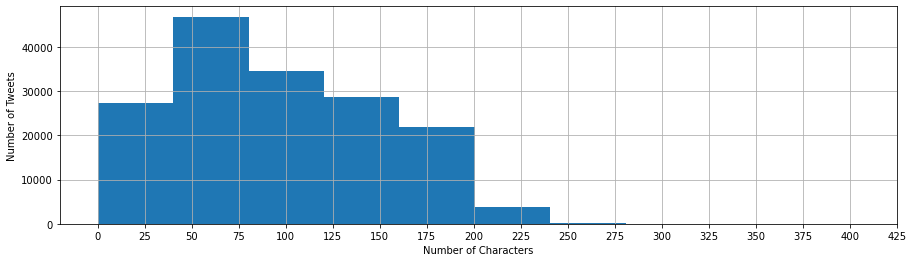

In [33]:
plt.figure(figsize= (15,4))
new_df['new_clean_tweet'].str.len().hist()
plt.xlabel('Number of Characters')
plt.ylabel('Number of Tweets')
plt.xticks(np.arange(0,450,25))
plt.show()

__Insight:__ The histogram shows that Tweets range from 5 to 425 characters and generally, it is between 2 to 250 characters.

#### Number of words appearing in each news headline.

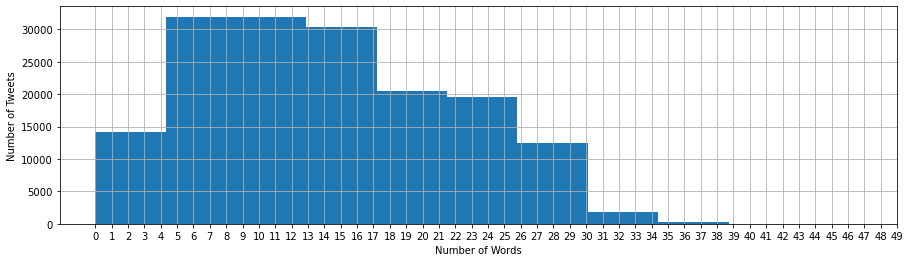

In [34]:
plt.figure(figsize= (15,4))
new_df['new_clean_tweet'].str.split().map(lambda x : len(x)).hist()
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.xticks(np.arange(0,50,1))
plt.show()

__Insight:__ It is clear that the number of words in cleaned tweet ranges from 1 to 45 and mostly falls between 5 to 18 words.

### Plot top stopwords

In [35]:
# function for Top Stopwords Barchart
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20] 
    x,y=zip(*top)
    plt.bar(x,y)

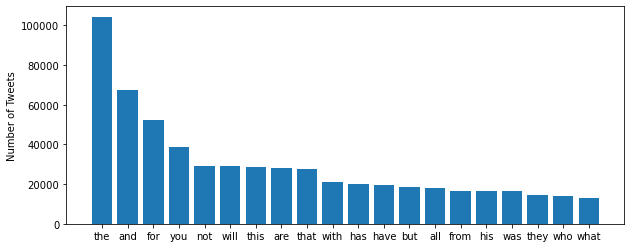

In [36]:
plt.figure(figsize= (10,4))
plot_top_stopwords_barchart(new_df['tweet'])
plt.ylabel('Number of Tweets')
plt.show()

__Insight:__ We can evidently see that stopwords such as “the”,” and”, “for” and “you” dominate in tweets

# Inspecting which words other than these stopwords occur frequently

In [37]:
from collections import Counter
import seaborn as sns
#Function for Top Non-Stopwords Barchart
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

Text(0, 0.5, 'Words in Original Tweets')

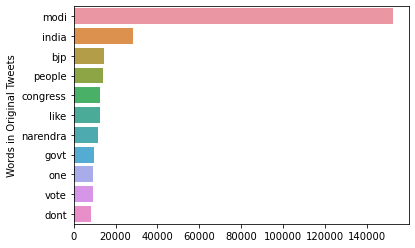

In [38]:
plot_top_non_stopwords_barchart(new_df['tweet'])
plt.ylabel('Words in Original Tweets')

Text(0, 0.5, 'Words in Cleaned Tweets')

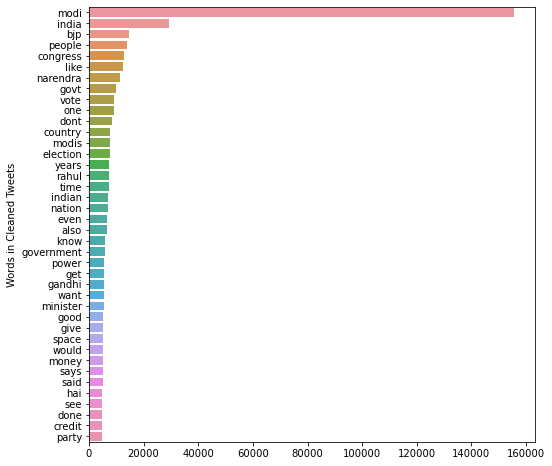

In [39]:
plt.figure(figsize= (8,8))
plot_top_non_stopwords_barchart(new_df['new_clean_tweet'])
plt.ylabel('Words in Cleaned Tweets')

## Ngram exploration

- Ngrams are simply contiguous sequences of n words. For example “riverbank”,” The three musketeers” etc.If the number of words is two, it is called bigram. For 3 words it is called a trigram and so on.
- Most frequent n-grams can give you a better understanding of the context in which the word was used.

In [40]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

### Function for Top N-grams Barchart

In [41]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

#### Bi-gram plot of Original Tweet

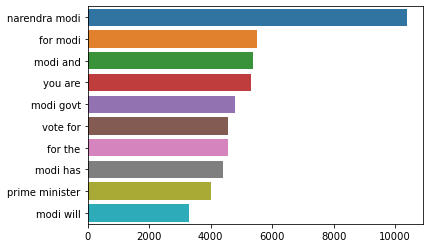

In [42]:
plot_top_ngrams_barchart(new_df['tweet'],2)

#### Bi-gram of Cleaned Tweet

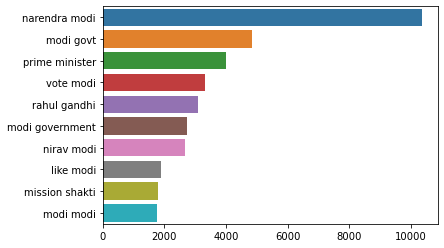

In [43]:
plot_top_ngrams_barchart(new_df['new_clean_tweet'],2)

#### Tri-gram of Original Tweet

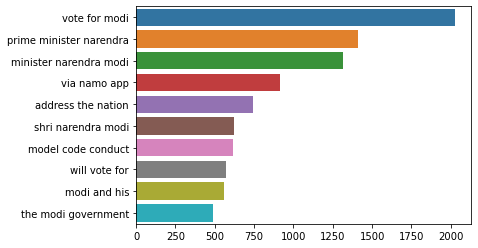

In [44]:
plot_top_ngrams_barchart(new_df['tweet'],3)

#### Tri-gram of Cleaned Tweet

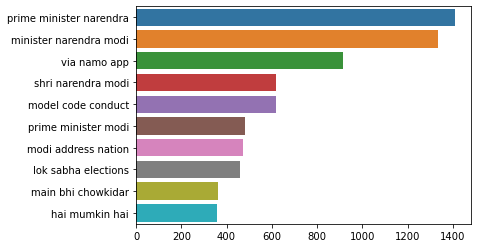

In [45]:
plot_top_ngrams_barchart(new_df['new_clean_tweet'],3)

__Insight__: After Visualizing the Bi- gram and tri-gram of the original tweet and cleaned tweet we can see that these tweets are political tweets and talks most about __Nrendra modi__, __Election__ etc.

### Checking the distribution of tweets by sentiments

<AxesSubplot:>

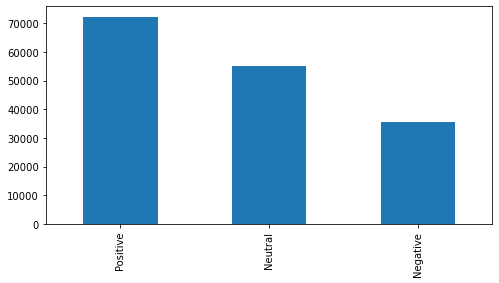

In [46]:
plt.figure(figsize=(8,4))
new_df['sentiment'].value_counts().plot.bar()

### Checking the count of Tweets in each category

In [47]:
temp = new_df.groupby('sentiment').count()['new_clean_tweet'].reset_index().sort_values(by='new_clean_tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,new_clean_tweet
2,Positive,72244
1,Neutral,55144
0,Negative,35509


### Checking the percentage of tweets in each category

In [48]:
new_df['sentiment'].value_counts(normalize=True)*100

Positive    44.349497
Neutral     33.852066
Negative    21.798437
Name: sentiment, dtype: float64

__Insight:__ Majority of the tweets contains Positive sentiments 

## Recap
- Till now we have cleaned our tweet data.
- We have analysed the tweets.

### Now We will focus on Model Building

# Preparing data For Modelling

- We will drop __tweet__, __clean_tweet__ and __sentiment__ column first from __new_df__ dataframe that we created for our data analysis.

In [49]:
new_df.drop(['tweet', 'clean_tweet', 'sentiment'], axis = 1, inplace = True)

In [50]:
new_df.columns

Index(['category', 'new_clean_tweet'], dtype='object')

In [51]:
#rearranging columns
cols = new_df.columns.to_list()
cols = cols[-1:-3:-1]
new_df= new_df[cols]

In [52]:
new_df.sample(5)

,new_clean_tweet,category
68568,excellent thread exhaustively well explained f...,1.0
129281,space adventure time slot required device face...,-1.0
115635,rahul gandhi haryana got idea minimum income s...,0.0
92174,already copying modi,0.0
160565,pakistan silently openly war everything unstab...,1.0


# Putting it all together

#### Ctreating final preprocess function
- create a function to clean the tweets finally applying stemming and lemmatization to each text so as to convert each word in root form which will decrease the dimensionaltiy of the whole text data.

In [53]:
def stem_lem_words(text):
    sent = []
    for word in text.split():
        #Applying Stemming then Applying lemmatization
        i = lemma.lemmatize(stemmer.stem(word))
        sent.append(i)
        
    text = ' '.join([elem for elem in sent]) #Converting the whole text into a string
    text = re.sub(' +', ' ', text) 
    return text
    
    print(result)

# Final Pre-process Function

In [54]:
def preprocess(text):
    text = clean_text(text) # First preprocessing the data
    text = stem_lem_words(text) #Finally stemming and lemmatizing the words
     
    return text

In [55]:
new_data = new_df.copy() #creating a copy of new_df

In [56]:
#Appliyg Final Pre-processing to our Data
new_data['new_clean_tweet'] = new_data['new_clean_tweet'].apply(stem_lem_words)

In [57]:
new_data.sample(10)

,new_clean_tweet,category
105252,modi convict famili return seat henc forth bas...,1.0
57296,marathi patrkar way worst town hall debat repo...,-1.0
11400,modi get reelect congressi scamster jail reaso...,-1.0
114227,reason vote modi transact charg card domest mo...,-1.0
146947,modi mortifi,0.0
156997,narendra modi dynam prime minist india ever wit,1.0
83641,modi,0.0
50558,true mani liber journalist politician want ant...,1.0
78811,plea challeng modi show detail mark sheet wait...,1.0
23098,sign democrat parti,0.0


In [58]:
#Saving final Cleaned Data
new_data.to_csv('final_cleaned_data.csv', index=False)